# Data and packages

In [1]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [2]:
os.getcwd()

'/Users/rafaeldossantospeixoto/Library/CloudStorage/OneDrive-JohnsHopkins/jefworks/crawdad/repos/crawdad_revision_analysis/running_code/squidpy'

In [3]:
meta = datatable.fread("exported_data/slide.csv")
meta = meta.to_pandas().set_index('C0')
meta.head()

x            y   celltypes
C0                                                  
GCCTTGCTGAGCTC  1044.848000  2216.560000    Bergmann
CCGATTAAAGCGGT  1564.224587  2055.398165    Bergmann
GACTGTGGGGGCGA  1969.008485  1596.198788  Fibroblast
GTGGGCGAGCTTCC  3146.278209   921.103284        MLI2
GGTTCGCGACCACA  1969.976889  1148.913778     Granule

In [4]:
meta.shape

(10098, 3)

# Squidpy

In [5]:
# just some random data for gene expression because I'm just interested in getting the coordinates and labels in there
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(10098, 50)

In [6]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})

In [7]:
adata.obs = meta

In [8]:
adata.obs

x            y         celltypes
C0                                                        
GCCTTGCTGAGCTC  1044.848000  2216.560000          Bergmann
CCGATTAAAGCGGT  1564.224587  2055.398165          Bergmann
GACTGTGGGGGCGA  1969.008485  1596.198788        Fibroblast
GTGGGCGAGCTTCC  3146.278209   921.103284              MLI2
GGTTCGCGACCACA  1969.976889  1148.913778           Granule
...                     ...          ...               ...
AAACCGAAGCAAAA   815.922243  1821.529720          Bergmann
TCACCAATACAAAC  1313.593333  1664.346667           Granule
CCCCATGGACCAAA  2472.796444  1885.980444  Oligodendrocytes
GAGGCTTGTTATAA  2083.715325  1319.879481          Bergmann
ACGGTGTAGACAAA  2836.823188  1092.572754           Granule

[10098 rows x 3 columns]

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


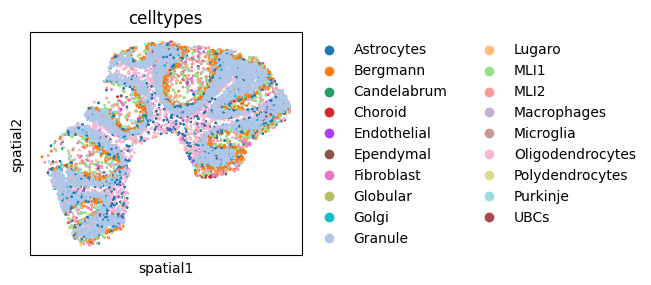

In [9]:
sq.pl.spatial_scatter(
        adata,
        shape = None,
        color = "celltypes",
        size=3
)

In [10]:
sq.gr.co_occurrence(adata, cluster_key = "celltypes")


/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:09<00:00,  9.15s/]


In [11]:
adata

AnnData object with n_obs × n_vars = 10098 × 50
    obs: 'x', 'y', 'celltypes'
    uns: 'celltypes_colors', 'celltypes_co_occurrence'
    obsm: 'spatial'

In [12]:
## get the co-occurance values
occ = adata.uns["celltypes_co_occurrence"]["occ"]
occ.shape

(19, 19, 49)

In [13]:
## get the intervals
intervals = adata.uns["celltypes_co_occurrence"]["interval"]
intervals.shape

(50,)

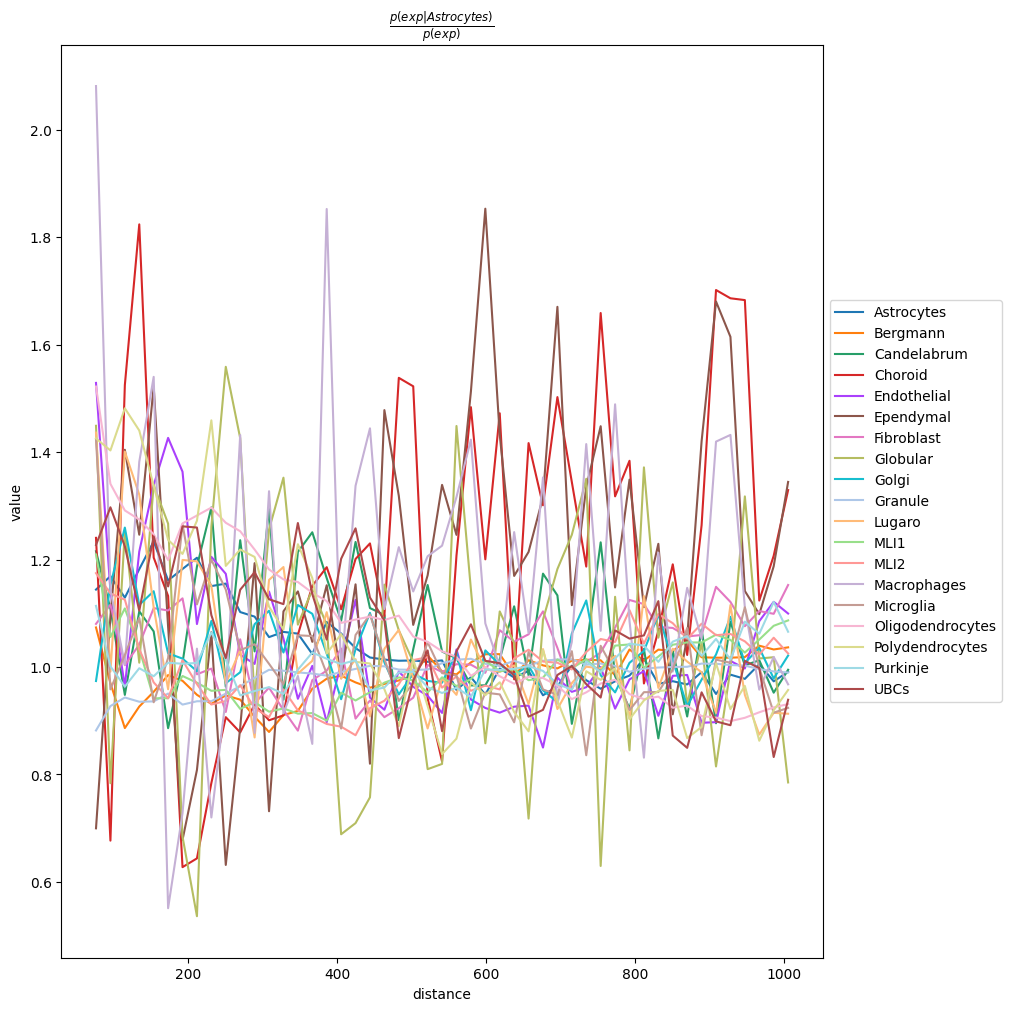

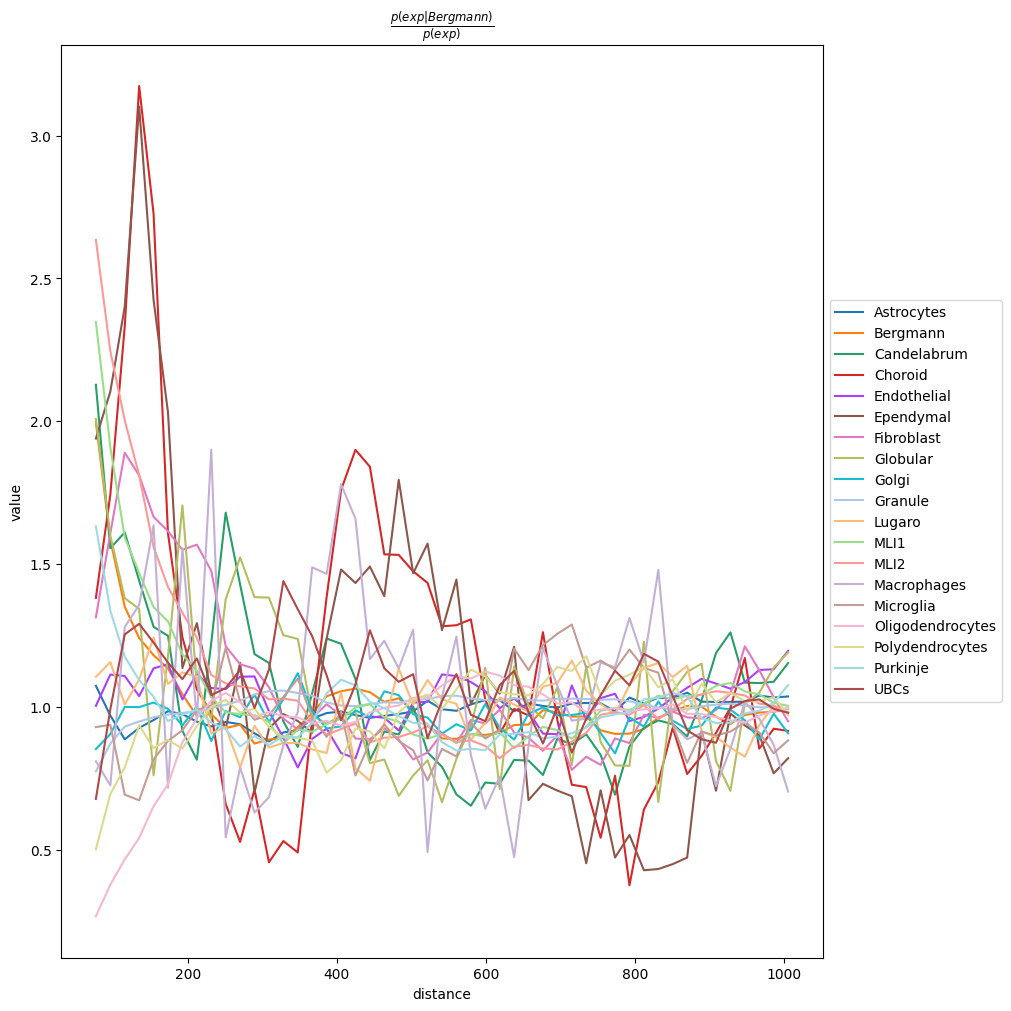

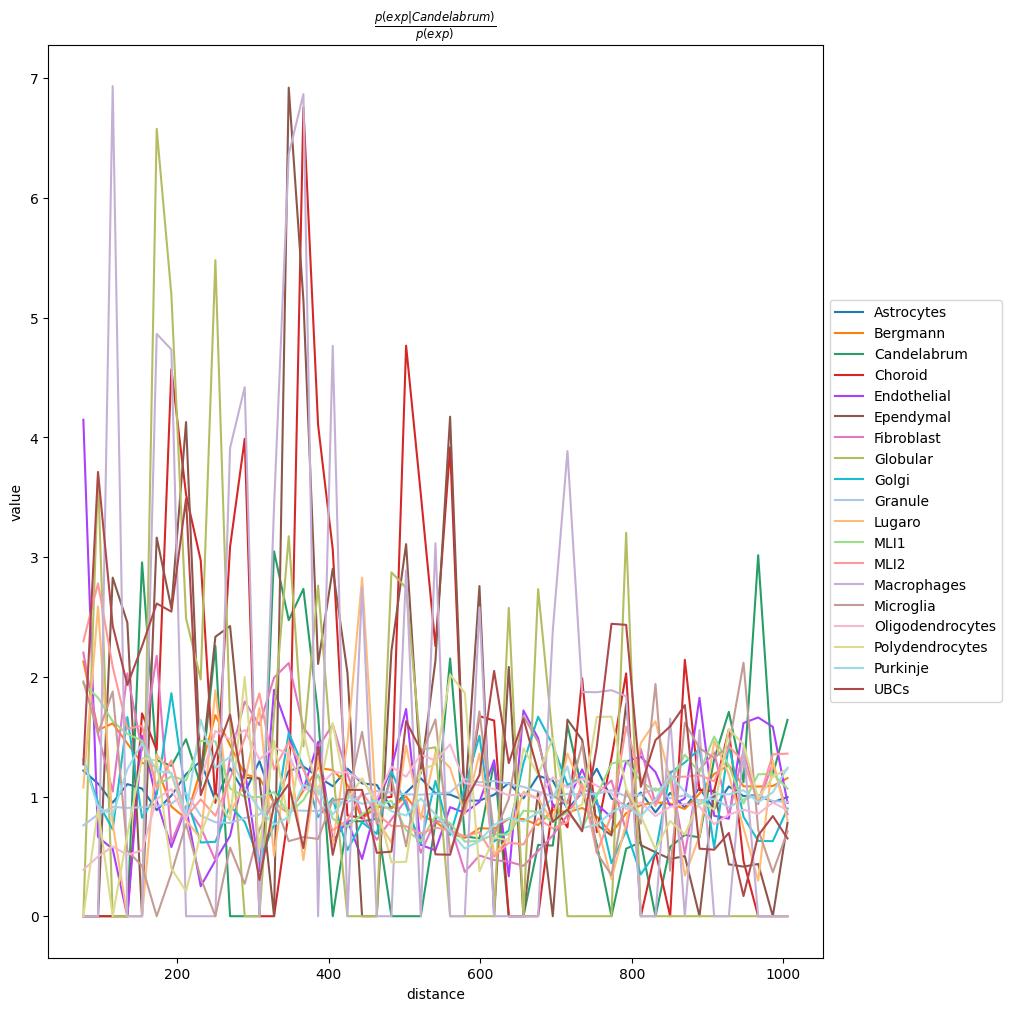

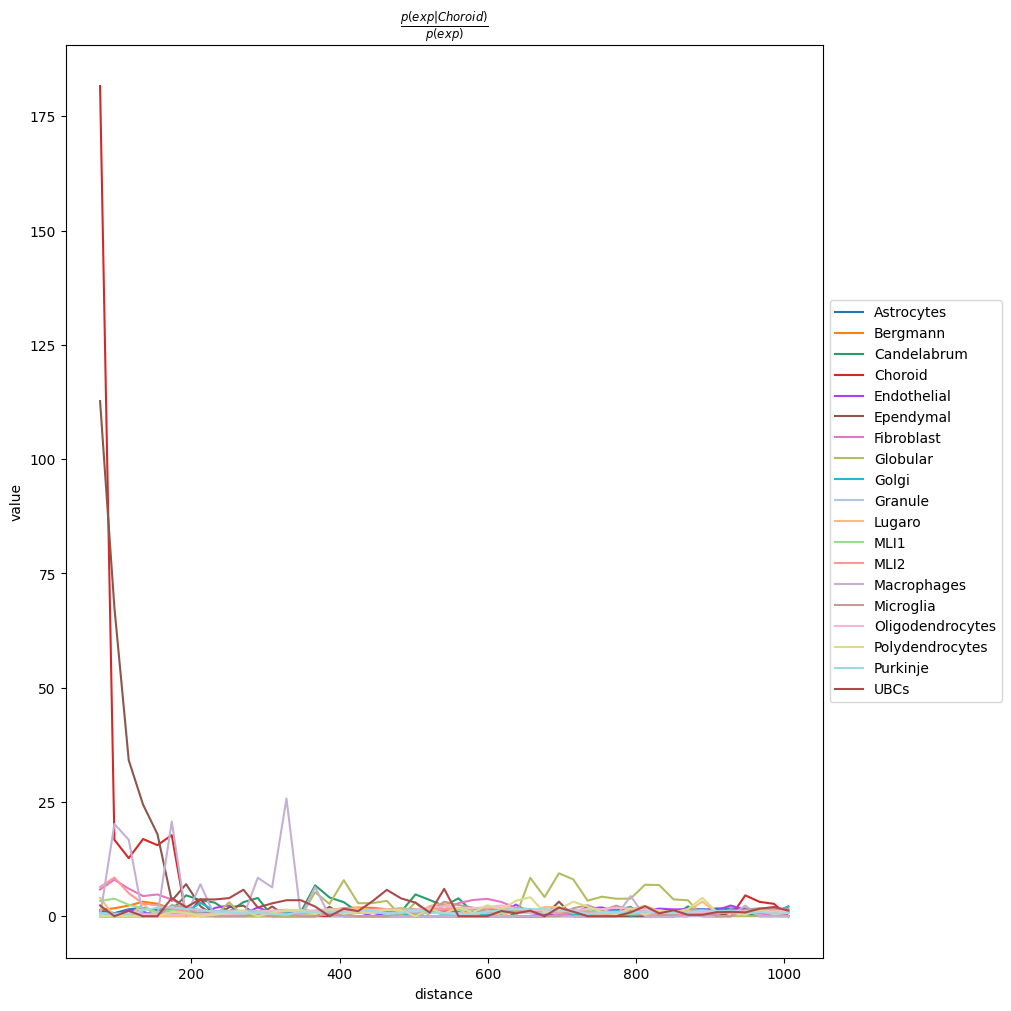

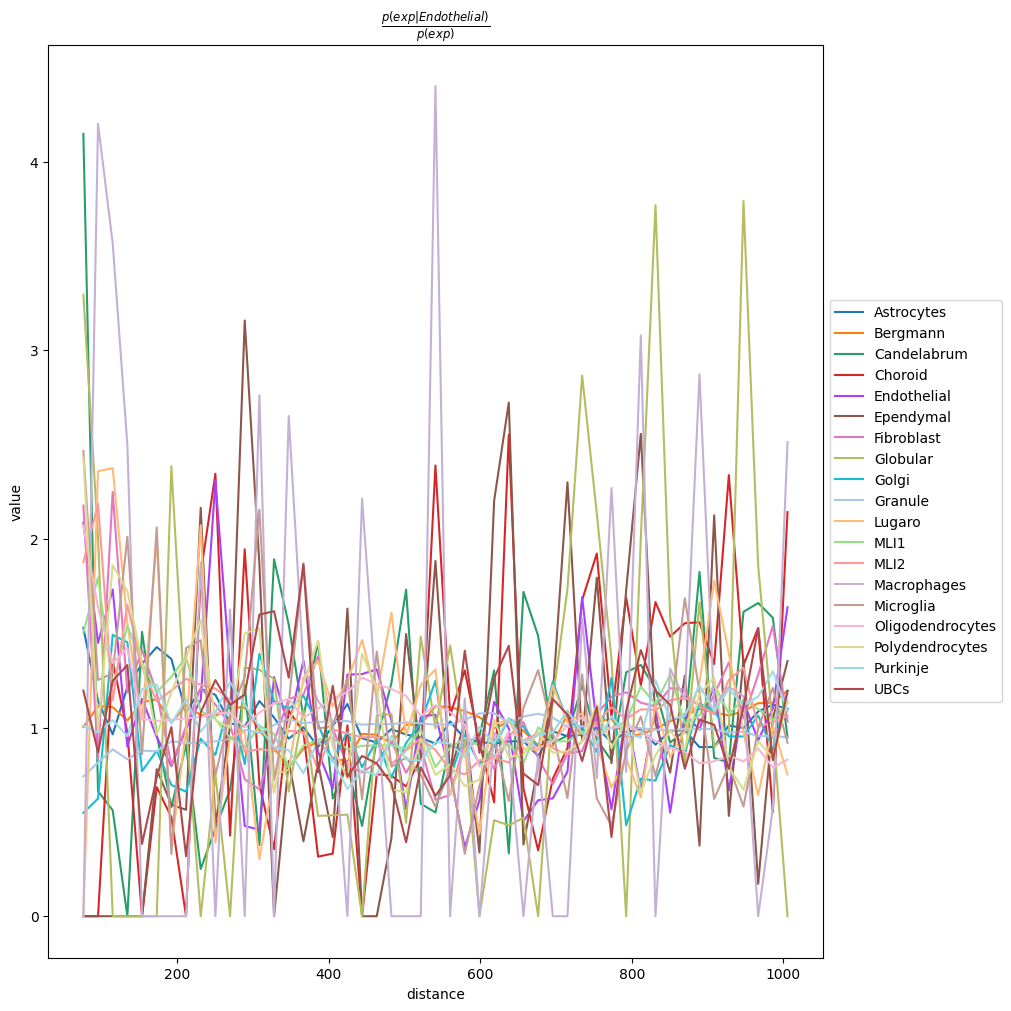

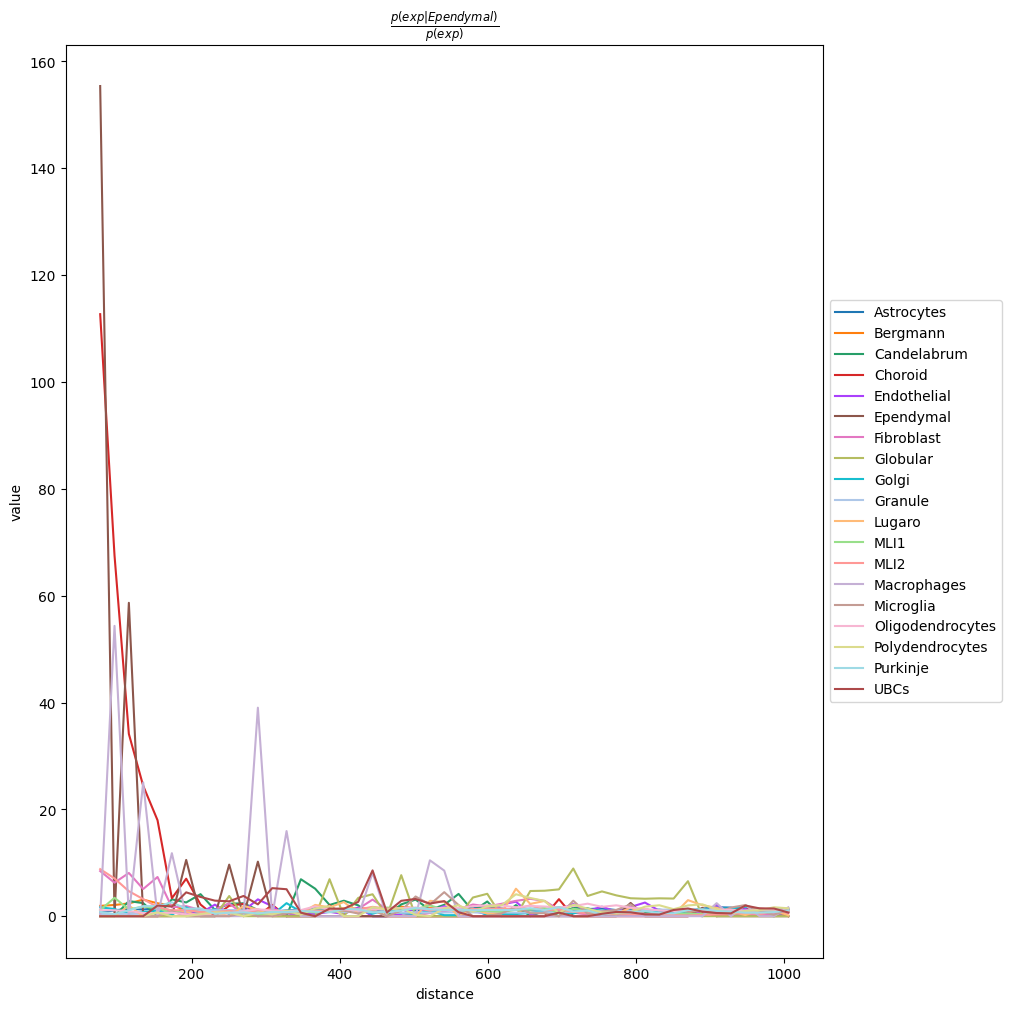

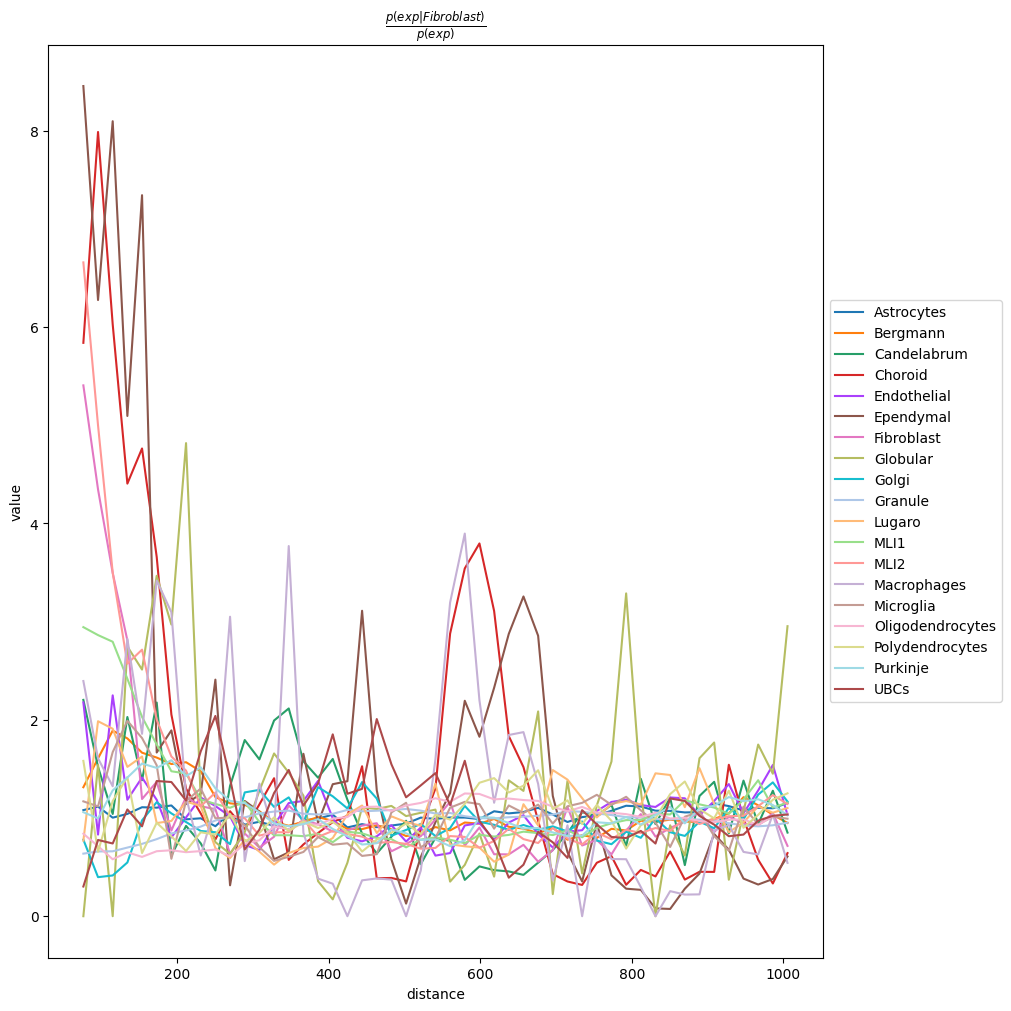

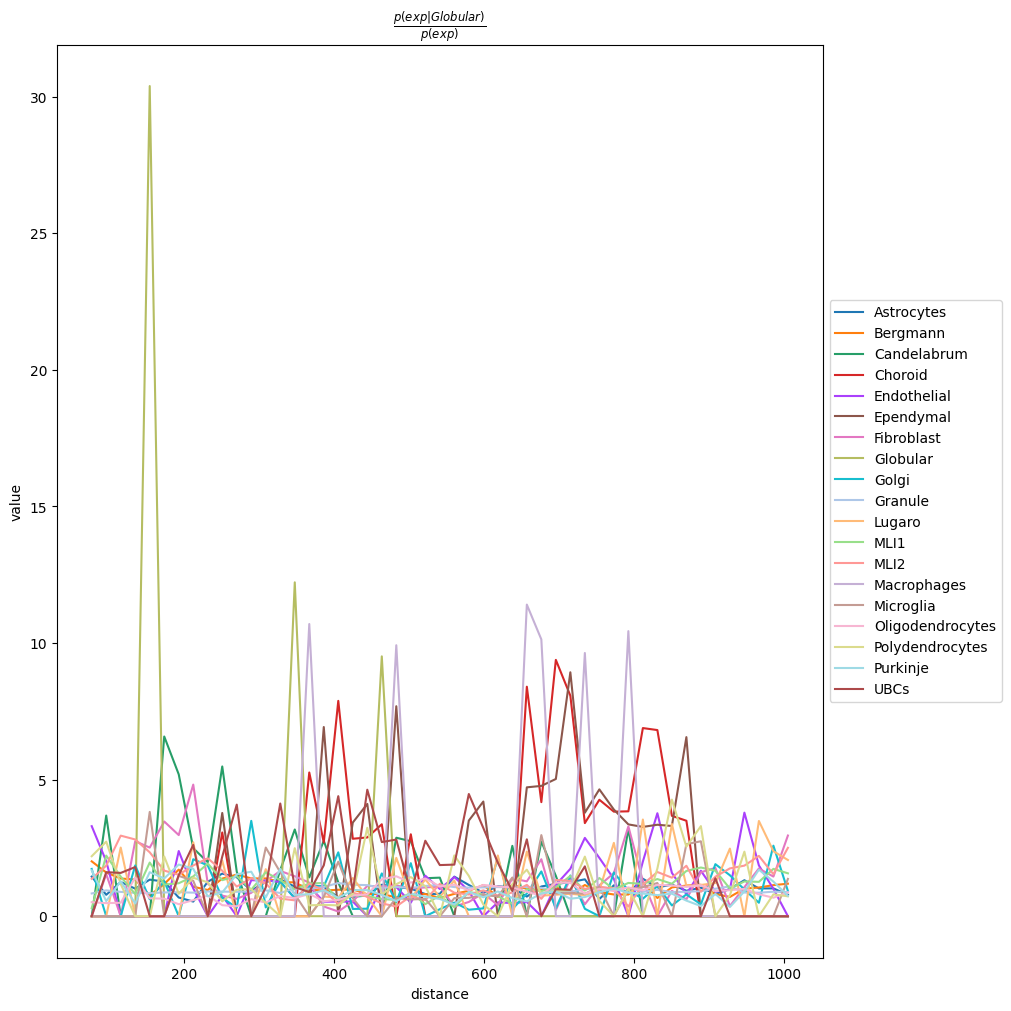

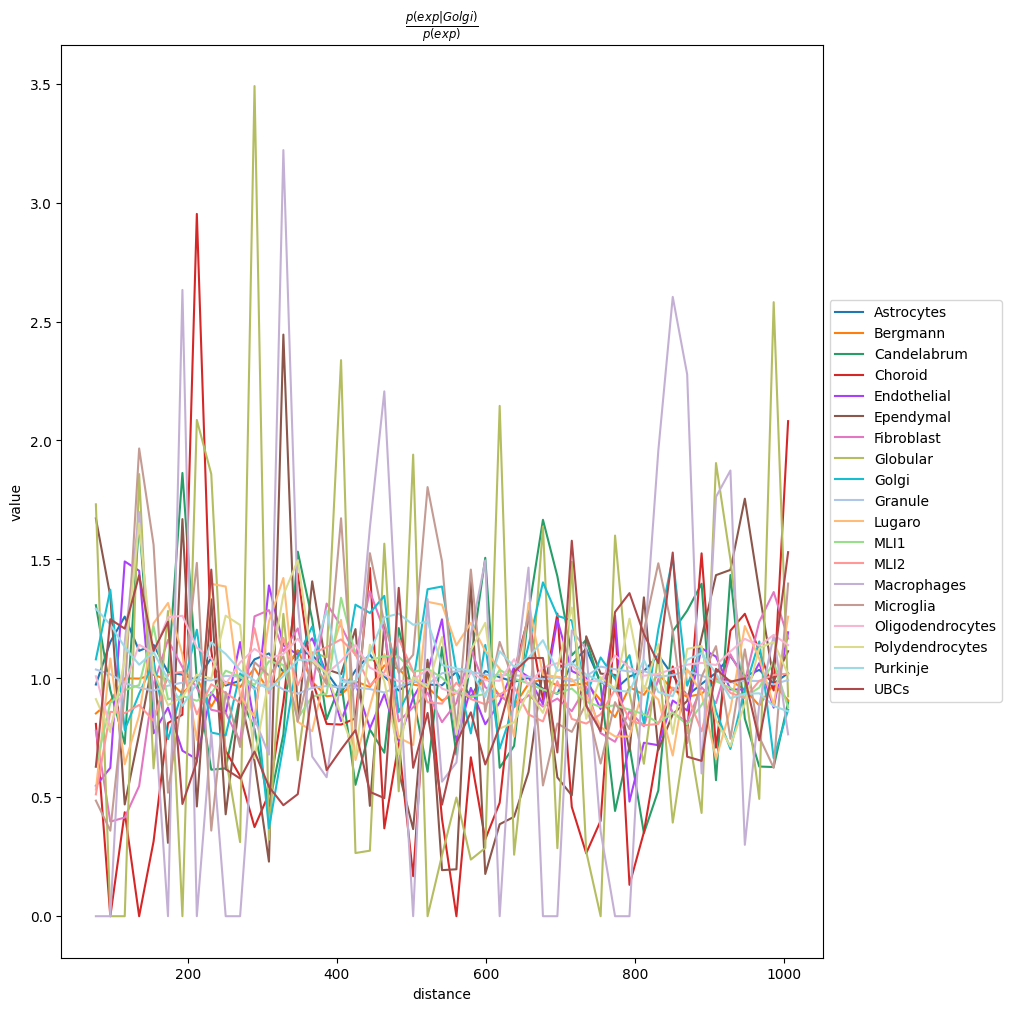

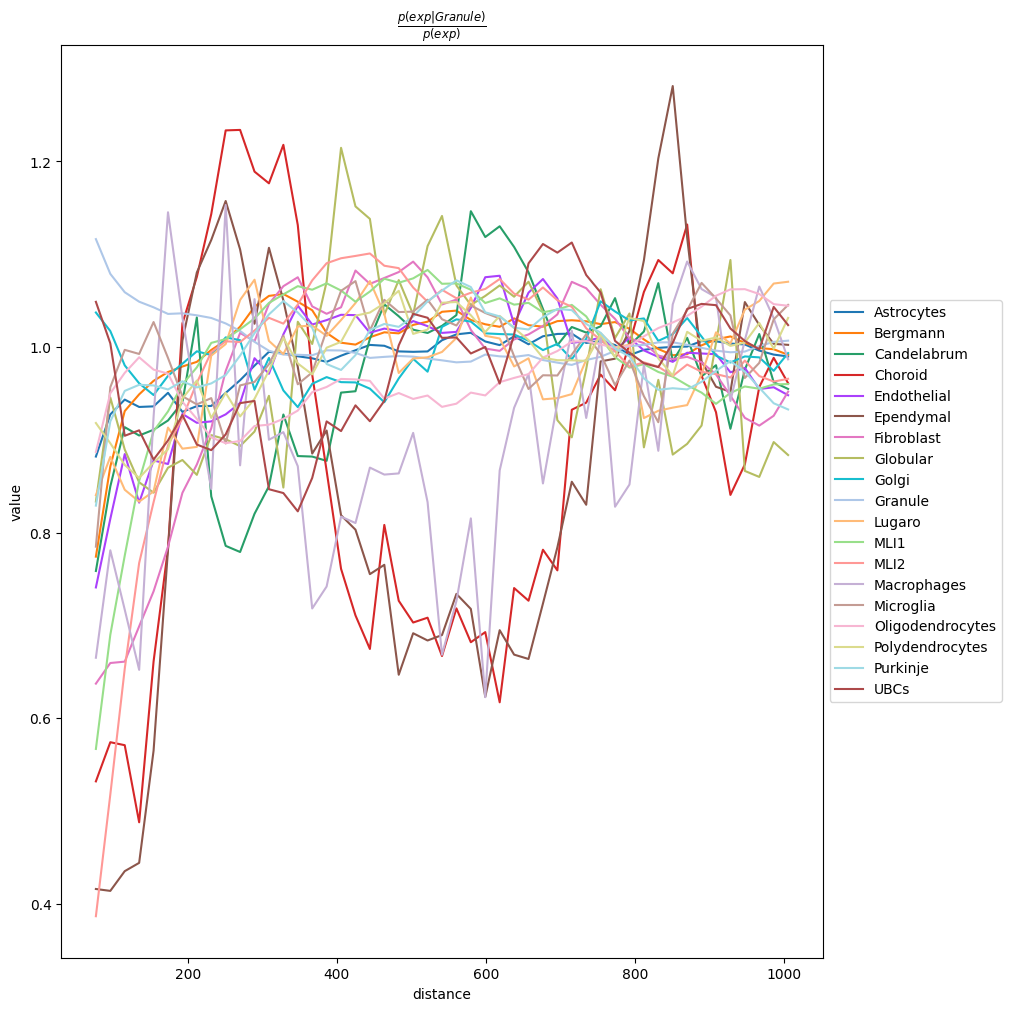

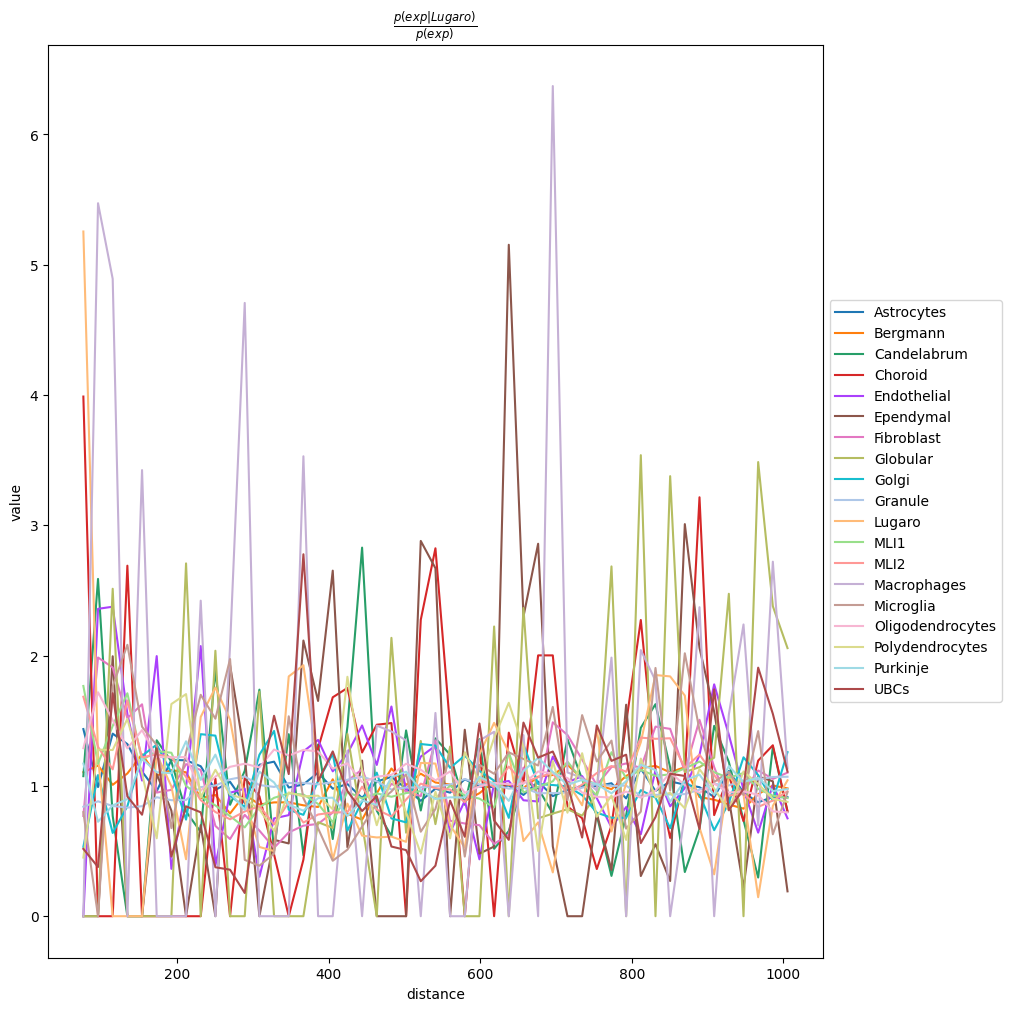

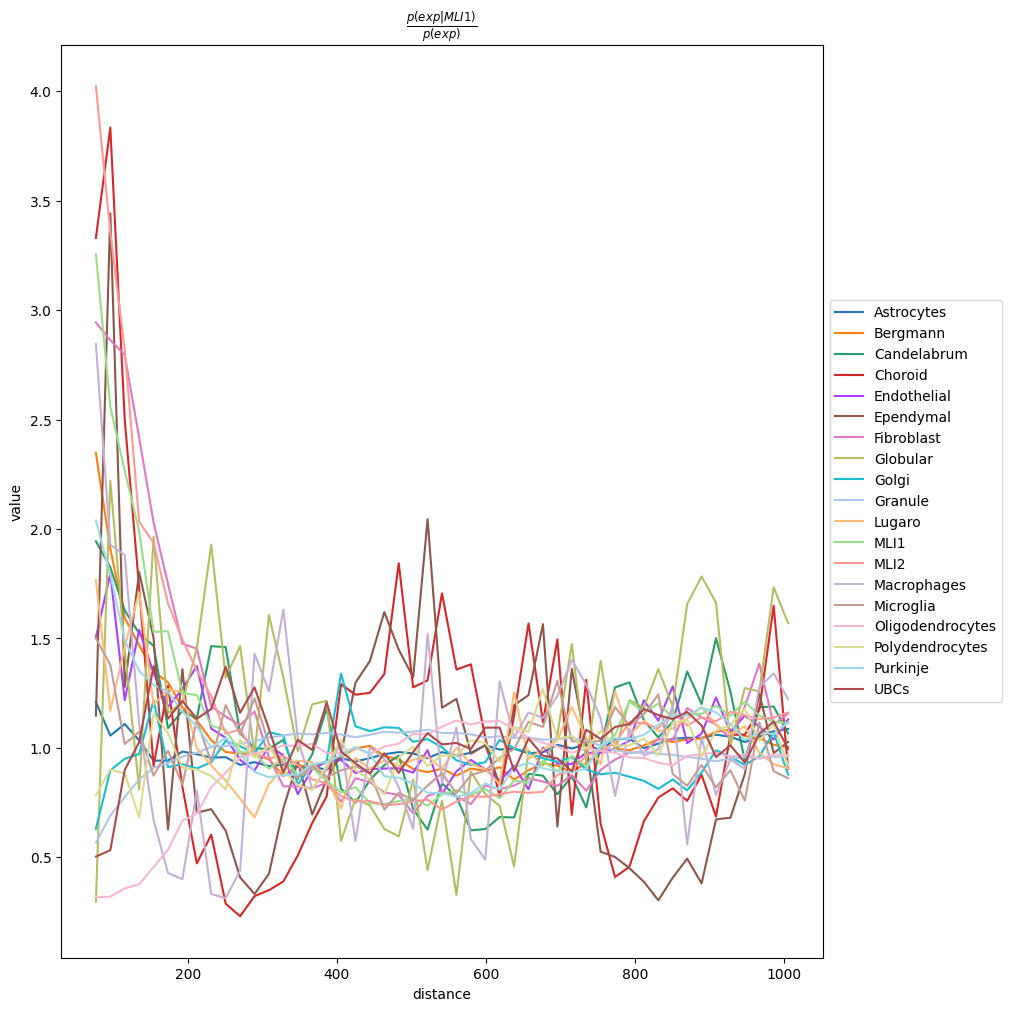

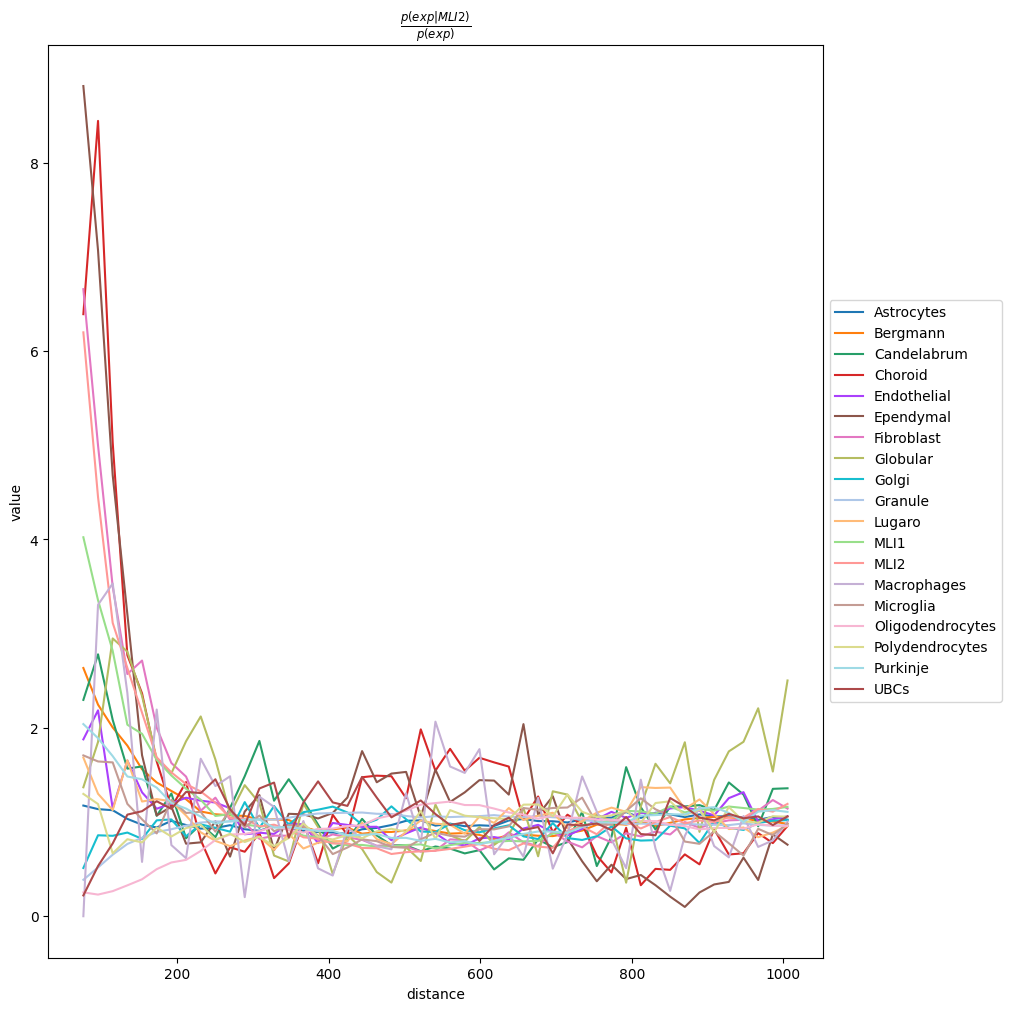

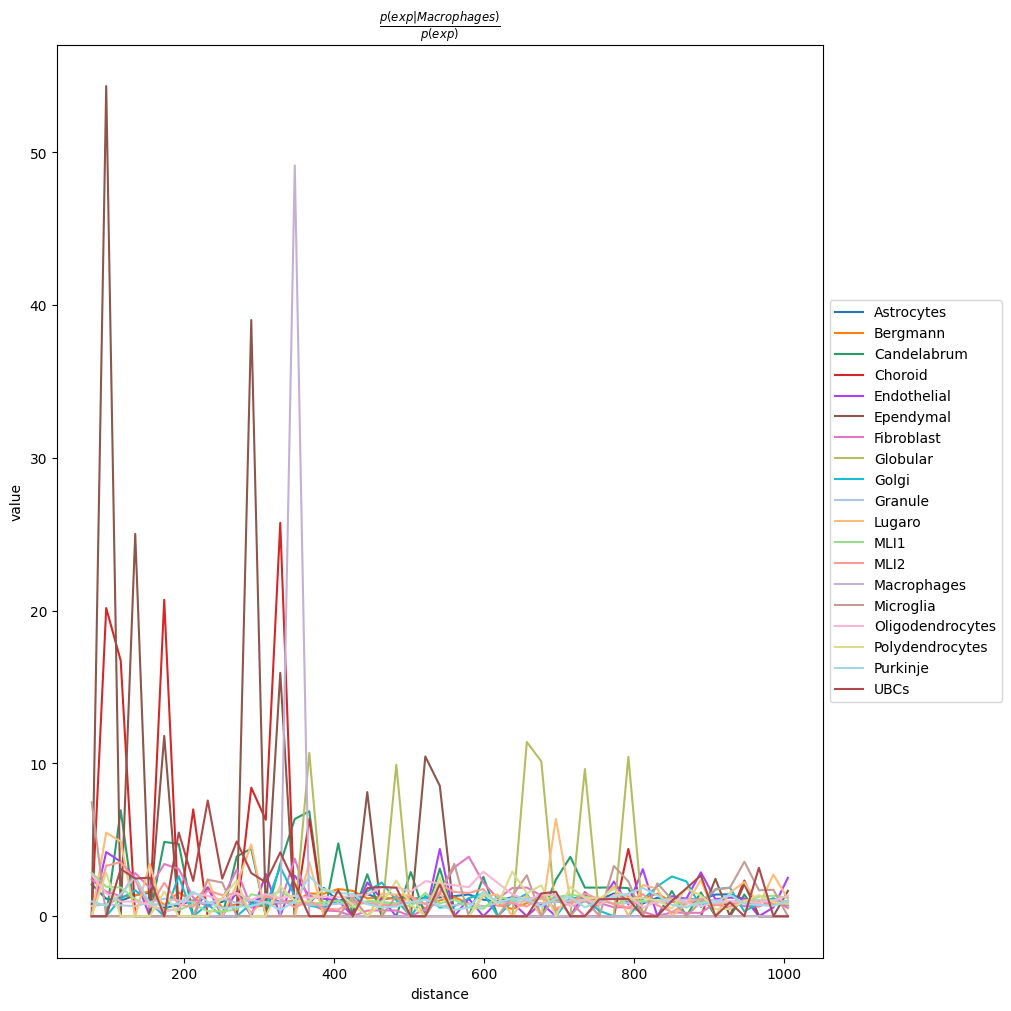

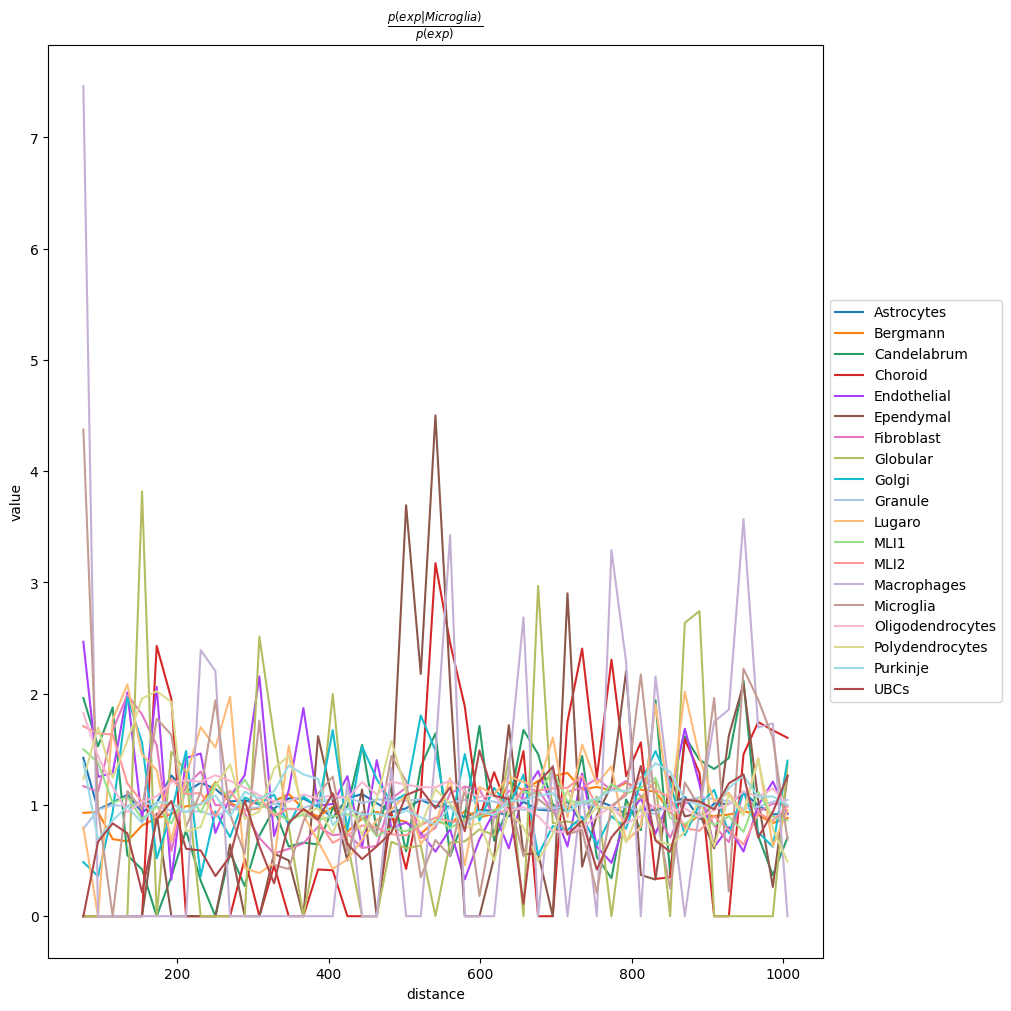

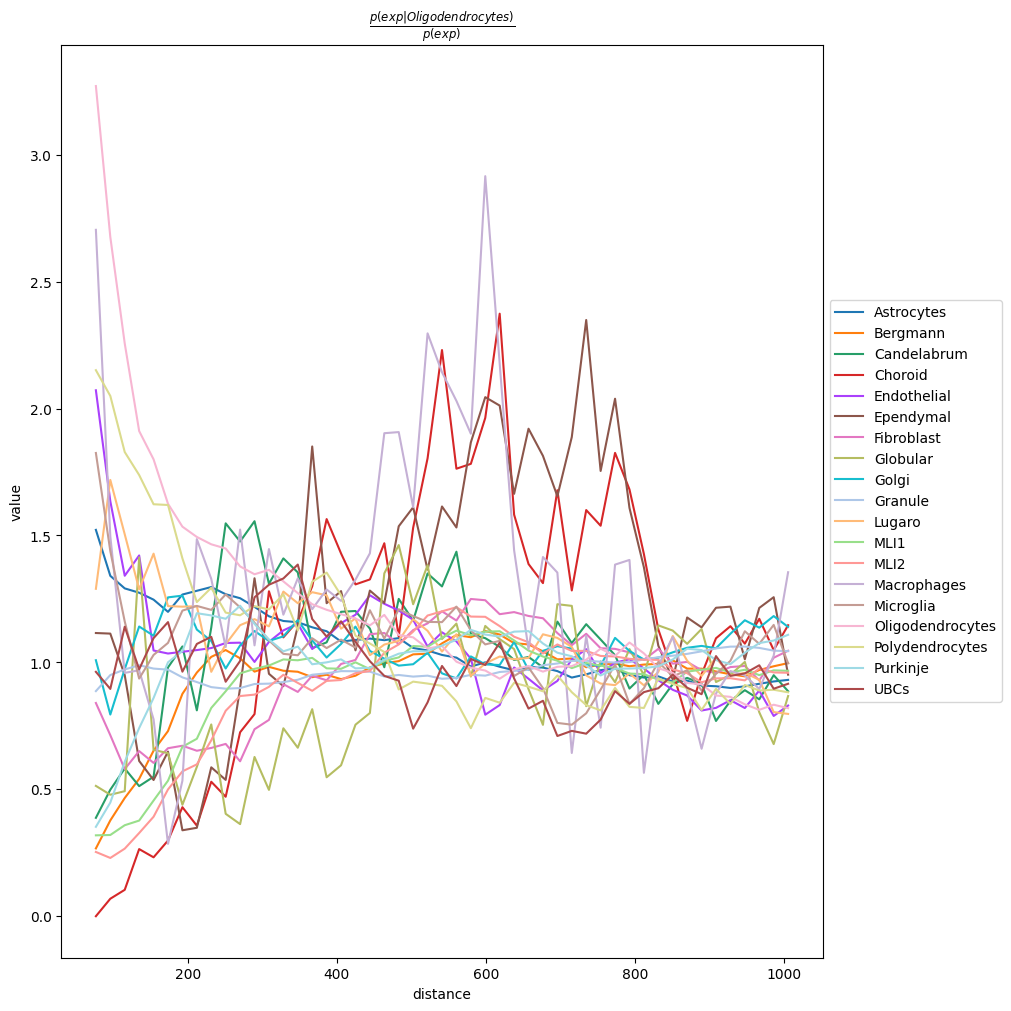

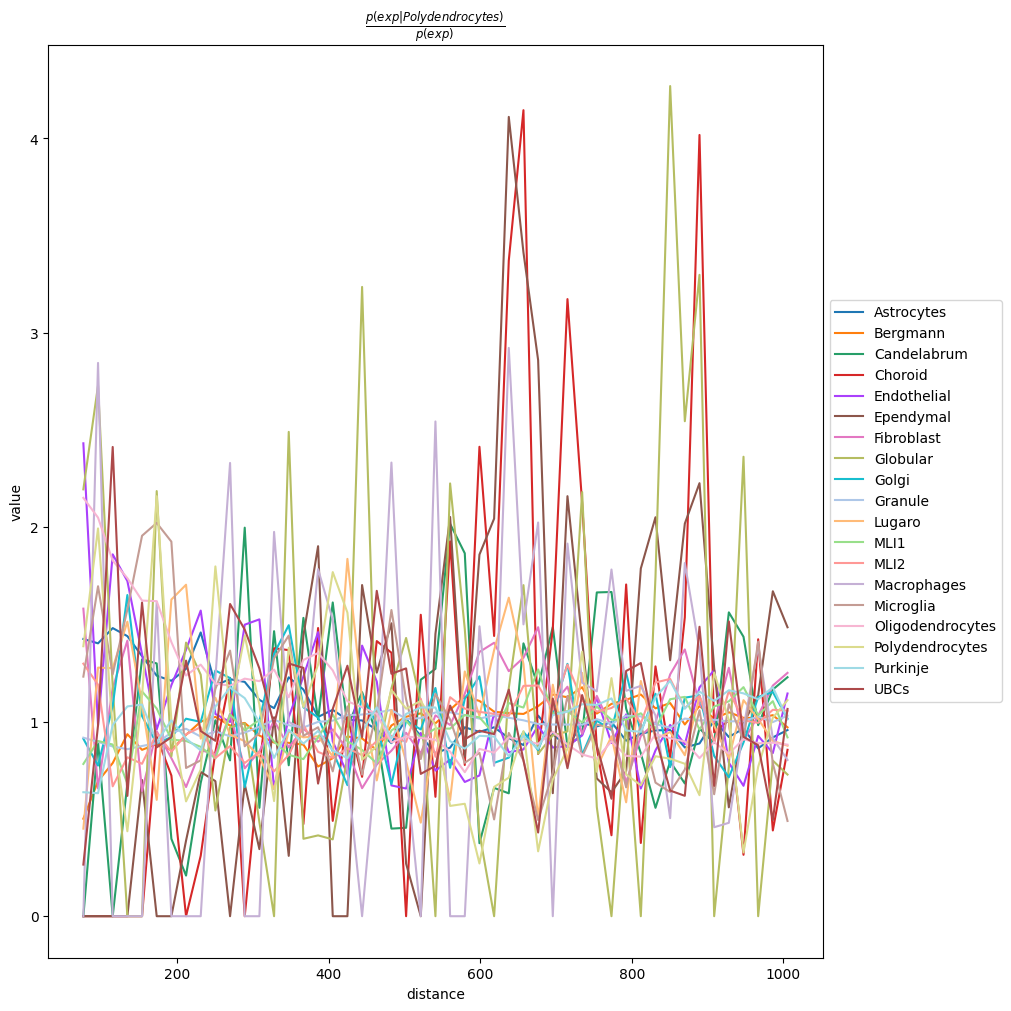

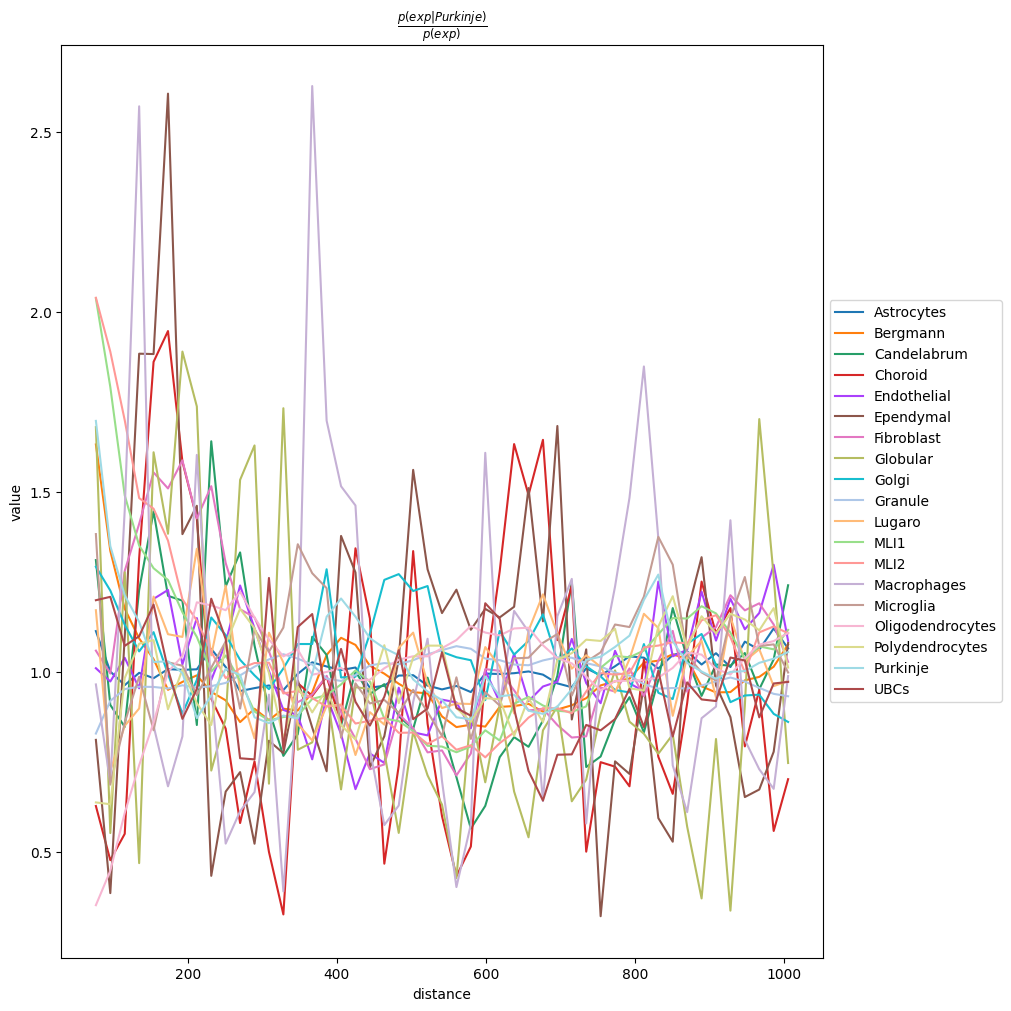

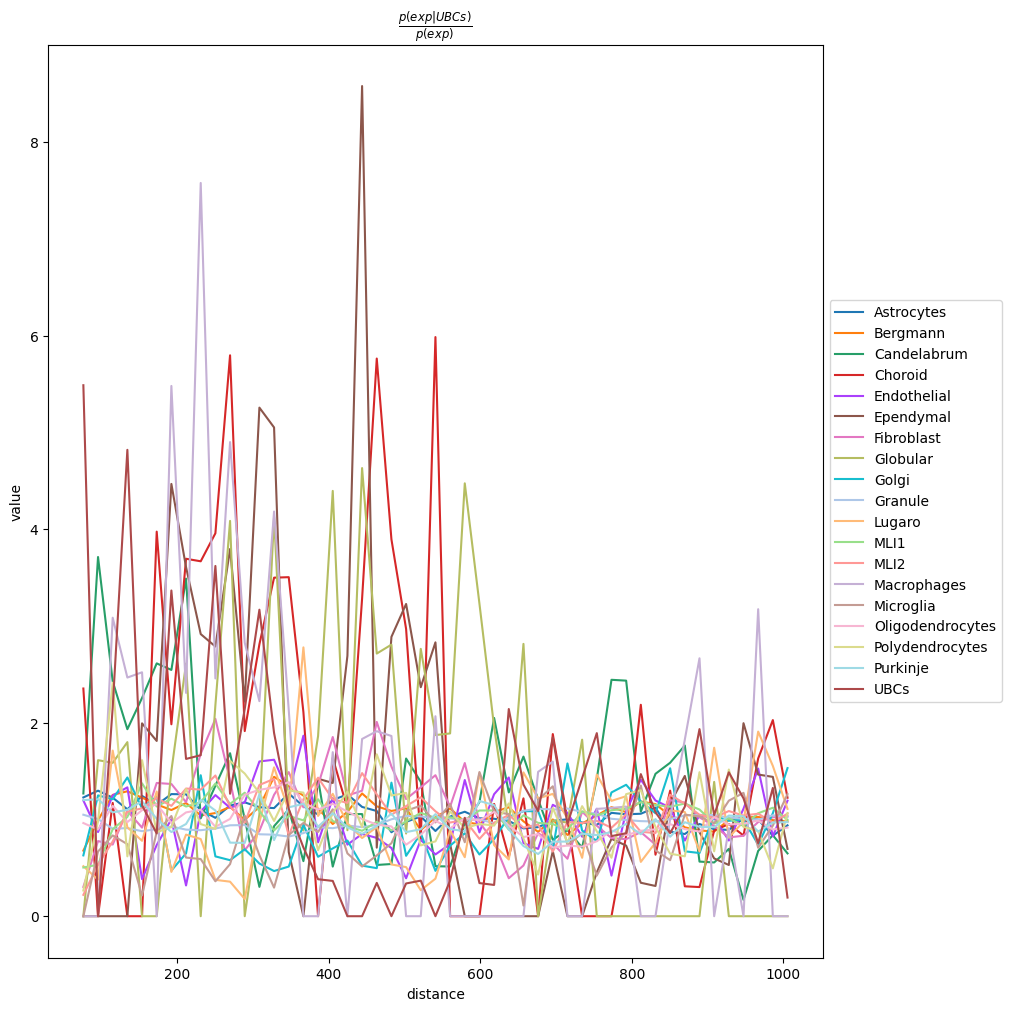

In [14]:
for ct in np.unique(adata.obs["celltypes"]):
    sq.pl.co_occurrence(adata, cluster_key="celltypes", clusters=ct,
                        save="simulation_co_occurance.{}.pdf".format(ct),
                        figsize=(10,10))

# Extract data

In [15]:
out = adata.uns["celltypes_co_occurrence"]["occ"]
interval = adata.uns["celltypes_co_occurrence"]["interval"][1:]
categories = adata.obs["celltypes"].cat.categories

## Create DF

In [16]:
cluster_key = "celltypes"

In [17]:
clusters = categories

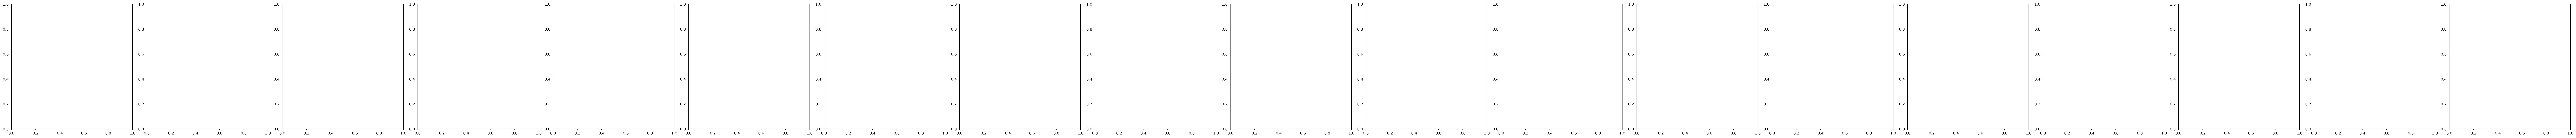

In [18]:
fig, axs = plt.subplots(
        1,
        len(clusters),
        figsize=(5 * len(clusters), 5),
        dpi=300,
        constrained_layout=True,
    )
axs = np.ravel(axs)

In [19]:
df_dict = {}

for g, ax in zip(clusters, axs):
        print(g)
        idx = np.where(categories == g)[0][0]
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df["reference"] = g
        df_dict[g] = df


Astrocytes
Bergmann
Candelabrum
Choroid
Endothelial
Ependymal
Fibroblast
Globular
Golgi
Granule
Lugaro
MLI1
MLI2
Macrophages
Microglia
Oligodendrocytes
Polydendrocytes
Purkinje
UBCs


In [20]:
result_df = pd.concat(df_dict.values(), axis=0, keys=df_dict.keys(), ignore_index=True)
result_df.head()

celltypes  probability    distance   reference
0  Astrocytes     1.144152   76.591072  Astrocytes
1  Astrocytes     1.169048   95.943756  Astrocytes
2  Astrocytes     1.129144  115.296432  Astrocytes
3  Astrocytes     1.182155  134.649124  Astrocytes
4  Astrocytes     1.233803  154.001801  Astrocytes

In [21]:
# > names(dat_50)
# [1] "perm"      "neighbor"  "Z"         "scale"     "reference" "id" 
# result_df.columns = ["neighbor", "Z", "scale", "reference"]
result_df.columns = ["neighbor", "probability", "distance", "reference"]

In [22]:
result_df["id"] = 0
result_df["perm"] = 1
result_df.head()

neighbor  probability    distance   reference  id  perm
0  Astrocytes     1.144152   76.591072  Astrocytes   0     1
1  Astrocytes     1.169048   95.943756  Astrocytes   0     1
2  Astrocytes     1.129144  115.296432  Astrocytes   0     1
3  Astrocytes     1.182155  134.649124  Astrocytes   0     1
4  Astrocytes     1.233803  154.001801  Astrocytes   0     1

In [23]:
result_df.to_csv('results_data/dat_slide_squidpy.csv')